# Example 2: Ensemble Kalman inversion for Lorenz 63 model

Here, we consider the discrete L63 system, with a forward Euler rule

$$ \begin{align*}
  z^{n+1} &= z^n + \Delta t f(z^n), \quad z \in \mathbb{R}^3, \quad n=0, 1, \ldots, \quad t = n \Delta t , \\
  z^0     &= z_0,
 \end{align*}  $$ 

where

$$ \begin{align*}
   f(z)   &=\left[\begin{array}{c}
       \lambda(y-x)\\
x(\beta-z)-y\\
xy-\gamma z
\end{array}\right] 
\end{align*} $$

and for chaotic behavior, we set

$$
  \lambda = 10, \quad \beta = 28, \quad \gamma = 8/3.
$$

## Ensemble Kalman Inversion

We use the ensemble Kalman filter for parameter estimation by adding a trivial dynamics for the inversion parameter, say $\lambda.$ The system to be solved by the ensemble filter becomes 

$$ \begin{align*}
  z_i^{n+1}    &= z_i^n + \Delta t f(z_i^n, \lambda_i^n),\quad i= 1, \ldots, M,\\
  \lambda^{n+1} &= \lambda^{n} + \sqrt{\Delta t} \; \varepsilon_i^n ,
 \end{align*}  $$ 
where $M$ is the number of ensemble members and $\varepsilon_i \sim \mathcal{N}(0,\sigma^{2}_{\varepsilon} )$. The role of the stochastic pertubation term is to spread out the ensemble, but this requires careful tuning of the noise variance $\sigma^2.$  An alternative, with better performance, is to use ensemble *inflation* on the foreacast state,  defined as 
$$
 z_i^f = \bar{z}_M^f + \alpha \Delta z_i^f,  
$$
where $\alpha > 1$ is the inflation factor, $\bar{z}_M^f$ is the ensemble mean of $z_i^f$ and the anomaly is defined as
$$
   \Delta z_i^f = z_i^f  - \bar{z}_M^f.
$$
We thus obtain multiplicative noise.

We will use an ensemble square root filter for the assimilation/inversion.

### Simulation parameters

We set the following parameter values for the simulations.

- $M=20$
- $\bar{z}^0 = (-0.587276, -0.563678, 16.8708)^{\mathrm{T}},$ $\lambda^0 = 9.$ 
- $\Delta t = 0.001$ and $\Delta t_{\mathrm{obs}} = 0.1$ 
- measurement error variance $R=8$
- inflation factors $\alpha = 1.005$ and $\alpha = 1.02$

In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

font_dir = ["/System/Library/Fonts/Supplemental/Skia"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

plt.rcParams.update({
    "font.family": "Skia"
})

plt.rcParams.update({
    "figure.figsize": (9, 6),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 14,
    "figure.titlesize": "xx-large",
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.axisbelow": True
})

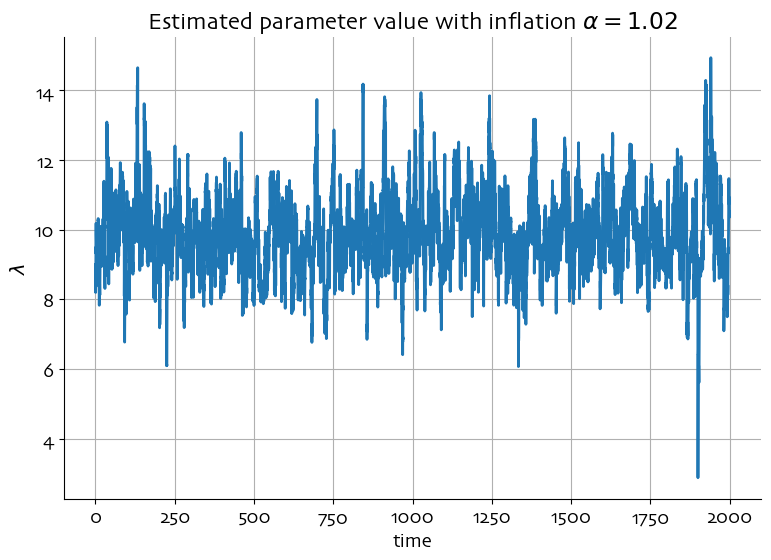

Estimated parameter value:  9.9075


In [15]:
import numpy as np

Nout = 100
dtobs = 0.10
dt = dtobs / Nout
STEPS = 20000
CAL = 100

R = 8.0

# Ensemble inflation
#inflation = 1.005
inflation = 1.02

# Ensemble size
M = 20

sigma = np.zeros(STEPS + 1)

# Initial value for state variable and parameter
u = np.array([-0.587276, -0.563678, 16.8708, 9])
uinit = u.copy()

time = np.zeros(STEPS + 1)
yobs = np.zeros((3, STEPS + 1))
time[0] = 0

yobs[:, 0] = u[:3] + np.sqrt(R) * np.random.randn(3)

ur = np.zeros((4, STEPS + 1))
ur[:, 0] = u

# Initial ensemble in state and parameter
X = np.zeros((4, M))
X[:3, :] = 1.0 * np.random.randn(3, M)
X[3, :] = 4 * (np.random.rand(M) - 1 / 2)
X = X - X @ np.ones((M, M)) / M + u[:, None]

sigma[0] = u[3]

# Ensemble square root Kalman filter
w = np.ones(M) / M
e = np.ones(M)
PP = np.eye(M) - np.outer(w, e)

xmean = X @ w

errorEnKF = 0

for i in range(STEPS):
    for ii in range(Nout):
        u0 = u.copy()
        u1 = u.copy()

        # Implicit midpoint rule
        for _ in range(4):
            um = (u1 + u0) / 2
            F = np.array([10 * (um[1] - um[0]), (28 - um[2]) * um[0] - um[1], um[0] * um[1] - 8 / 3 * um[2], 0])
            u = u0 + dt * F
            u1 = u.copy()

    time[i + 1] = dt * Nout * (i + 1)
    yobs[:, i + 1] = u[:3] + np.sqrt(R) * np.random.randn(3)
    ur[:, i + 1] = u

    for ii in range(Nout):
        X0 = X.copy()
        X1 = X.copy()

        # Implicit midpoint rule
        for _ in range(4):
            Xm = 1 / 2 * (X1 + X0)
            FX = np.array([Xm[3, :] * (Xm[1, :] - Xm[0, :]), (28 - Xm[2, :]) * Xm[0, :] - Xm[1, :], 
                           Xm[0, :] * Xm[1, :] - 8 / 3 * Xm[2, :], np.zeros(M)])
            X = X0 + dt * FX
            X1 = X.copy()

    xmean = X @ w
    dX = inflation * X @ PP
    Psi = (1 / (M - 1)) * dX @ dX.T
    X = xmean[:, None] @ e[None, :] + dX

    T = np.eye(M) - dX[:3, :].T @ np.linalg.inv(Psi[:3, :3] + R * np.eye(3)) @ dX[:3, :] / (M - 1)
    U, D, V = np.linalg.svd(T)
    T = U @ np.sqrt(np.diag(D)) @ V

    dX = dX @ T

    xmean = xmean - Psi[:, :3] @ np.linalg.inv(Psi[:3, :3] + R * np.eye(3)) @ (xmean[:3] - yobs[:, i + 1])
    
    X = xmean[:, None] @ e[None, :] + dX

    sigma[i + 1] = xmean[3]

    if i >= CAL:
        errorEnKF += np.linalg.norm((xmean - ur[:, i + 1]) / np.sqrt(3)) ** 2

errorEnKF = np.sqrt(errorEnKF / (STEPS - CAL))

plt.figure()
plt.plot(time, sigma, '-', linewidth=2.0)
plt.xlabel('time')
plt.ylabel(r'$\lambda$')
#plt.title(r'Estimated parameter value with inflation $\alpha = 1.005$')
plt.title(r'Estimated parameter value with inflation $\alpha = 1.02$')
plt.grid()
#plt.savefig("estLambda_1p005.png")
plt.savefig("estLambda_1p02.png")
plt.show()

parameter_value = np.mean(sigma)
print("Estimated parameter value: %7.4f" % parameter_value)